# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8',
    'torchvision': '0.9.0',
    'tensorboard': '2.7.0',
    'pytorch_lightning': '1.5.0',
    'torchmetrics': '0.6.2'
}
check_packages(d)

[OK] Your Python version is 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
[OK] torch 2.1.0
[OK] torchvision 0.16.0
[OK] tensorboard 2.15.1
[OK] pytorch_lightning 2.1.0
[OK] torchmetrics 1.2.0


# Chapter 13: Going Deeper -- the Mechanics of PyTorch (Part 3/3)

**Outline**

- [Higher-level PyTorch APIs: a short introduction to PyTorch Lightning](#Higher-level-PyTorch-APIs-a-short-introduction-to-PyTorch-Lightning)
  - [Setting up the PyTorch Lightning model](#Setting-up-the-PyTorch-Lightning-model)
  - [Setting up the data loaders for Lightning](#Setting-up-the-data-loaders-for-Lightning)
  - [Training the model using the PyTorch Lightning Trainer class](#Training-the-model-using-the-PyTorch-Lightning-Trainer-class)
  - [Evaluating the model using TensorBoard](#Evaluating-the-model-using-TensorBoard)
- [Summary](#Summary)

## Higher-level PyTorch APIs: a short introduction to PyTorch Lightning

### Setting up the PyTorch Lightning model

## Higher-level PyTorch APIs: a short introduction to PyTorch Lightning

### Setting up the PyTorch Lightning model

In [3]:
import pytorch_lightning as pl
import torch 
import torch.nn as nn 

from torchmetrics import __version__ as torchmetrics_version
from pkg_resources import parse_version

from torchmetrics import Accuracy

In [21]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        
        # new PL attributes:
        
        if parse_version(torchmetrics_version) > parse_version("0.8"):
            self.train_acc = Accuracy(task="multiclass", num_classes=10)
            self.valid_acc = Accuracy(task="multiclass", num_classes=10)
            self.test_acc = Accuracy(task="multiclass", num_classes=10)
        else:
            self.train_acc = Accuracy()
            self.valid_acc = Accuracy()
            self.test_acc = Accuracy()
        
        # Model similar to previous section:
        input_size = image_shape[0] * image_shape[1] * image_shape[2] 
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units: 
            layer = nn.Linear(input_size, hidden_unit) 
            all_layers.append(layer) 
            all_layers.append(nn.ReLU()) 
            input_size = hidden_unit 
 
        all_layers.append(nn.Linear(hidden_units[-1], 10)) 
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

### Setting up the data loaders

In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
 
from torchvision.datasets import MNIST
from torchvision import transforms

In [23]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        MNIST(root=self.data_path, download=True) 

    def setup(self, stage=None):
        # stage is either 'fit', 'validate', 'test', or 'predict'
        # here note relevant
        mnist_all = MNIST( 
            root=self.data_path,
            train=True,
            transform=self.transform,  
            download=False
        ) 

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST( 
            root=self.data_path,
            train=False,
            transform=self.transform,  
            download=False
        ) 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4)
    
    
torch.manual_seed(1) 
mnist_dm = MnistDataModule()

### Training the model using the PyTorch Lightning Trainer class

In [24]:
from pytorch_lightning.callbacks import ModelCheckpoint


mnistclassifier = MultiLayerPerceptron()

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, accelerator='gpu', devices=1)
else:
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0     
1 | valid_acc | MulticlassAccuracy | 0     
2 | test_acc  | MulticlassAccuracy | 0     
3 | model     | Sequential         | 25.8 K
-------------------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)


c:\Users\jakep\Coding\miniconda3\envs\pyml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 860/860 [00:23<00:00, 37.14it/s, v_num=4, train_loss=0.260, valid_loss=0.166, valid_acc=0.949]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 860/860 [00:23<00:00, 37.14it/s, v_num=4, train_loss=0.260, valid_loss=0.166, valid_acc=0.949]


### Evaluating the model using TensorBoard

In [25]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')

Restoring states from the checkpoint path at c:\Users\jakep\OneDrive\Desktop\Projects\machine-learning-book\ch13\lightning_logs\version_4\checkpoints\epoch=8-step=7740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\jakep\OneDrive\Desktop\Projects\machine-learning-book\ch13\lightning_logs\version_4\checkpoints\epoch=8-step=7740.ckpt
c:\Users\jakep\Coding\miniconda3\envs\pyml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 151.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9499600529670715
        test_loss           0.14912296831607819
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.14912296831607819, 'test_acc': 0.9499600529670715}]

In [26]:
from IPython.display import Image

Image(filename='figures/13_09.png') 

OSError: [Errno 22] Invalid argument

In [35]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 38012), started 0:16:26 ago. (Use '!kill 38012' to kill it.)

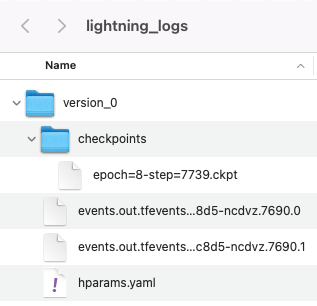

In [11]:
Image(filename='figures/13_10.png') 

In [34]:
path = 'lightning_logs/version_4/checkpoints/epoch=8-step=7740.ckpt'

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(
        max_epochs=15, callbacks=callbacks, accelerator='gpu', devices=1
    )
else:
    trainer = pl.Trainer(
        max_epochs=15, callbacks=callbacks, resume_from_checkpoint=path
    )

trainer.fit(model=mnistclassifier, datamodule=mnist_dm, ckpt_path=path)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at lightning_logs/version_4/checkpoints/epoch=8-step=7740.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0     
1 | valid_acc | MulticlassAccuracy | 0     
2 | test_acc  | MulticlassAccuracy | 0     
3 | model     | Sequential         | 25.8 K
-------------------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)
Restored all states from the checkpoint at lightning_logs/version_4/check

Epoch 14: 100%|██████████| 860/860 [00:29<00:00, 29.31it/s, v_num=5, train_loss=0.158, valid_loss=0.168, valid_acc=0.952]  

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 860/860 [00:29<00:00, 29.30it/s, v_num=5, train_loss=0.158, valid_loss=0.168, valid_acc=0.952]


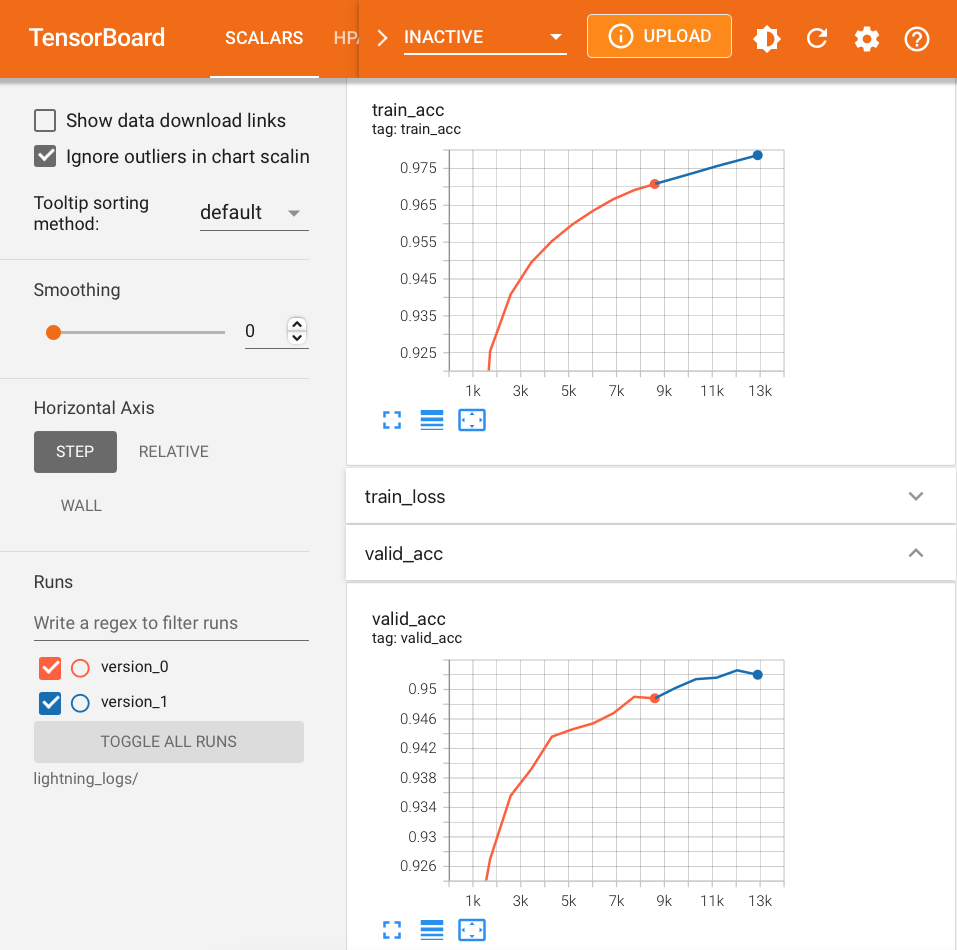

In [14]:
from IPython.display import Image
Image(filename='figures/13_11.png') 

In [13]:
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 702), started 0:02:27 ago. (Use '!kill 702' to kill it.)

In [15]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9542893767356873, 'test_loss': 0.14718961715698242}
--------------------------------------------------------------------------------


[{'test_loss': 0.14718961715698242, 'test_acc': 0.9542893767356873}]

In [16]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')

Restoring states from the checkpoint path at /home/jovyan/ch13/lightning_logs/version_0/checkpoints/epoch=13-step=12039.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/jovyan/ch13/lightning_logs/version_0/checkpoints/epoch=13-step=12039.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9559454321861267, 'test_loss': 0.14512717723846436}
--------------------------------------------------------------------------------


[{'test_loss': 0.14512717723846436, 'test_acc': 0.9559454321861267}]

In [17]:
path = "lightning_logs/version_0/checkpoints/epoch=13-step=12039.ckpt"
model = MultiLayerPerceptron.load_from_checkpoint(path)

## Summary

---

Readers may ignore the next cell.

In [18]:
! python ../.convert_notebook_to_script.py --input ch13_part3_lightning.ipynb --output ch13_part3_lightning.py

[NbConvertApp] Converting notebook ch13_part3_lightning.ipynb to script
[NbConvertApp] Writing 7321 bytes to ch13_part3_lightning.py
